In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
# import theano
from PIL import Image
from numpy import *
# SKLEARN
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [28]:

# input image dimensions
img_rows, img_cols = 50, 50

# number of channels
img_channels = 1

#%%
#  data
# 
# path1 = 'data/train/cats'    #path of folder of images    
path2 = 'data/train/resize50'  #path of folder to save images    


# listing = os.listdir(path1) 
# num_samples=size(listing)
# print (num_samples)
num_samples = 24407
# for file in listing:
#     im = Image.open(path1 + '/' + file)   
#     img = im.resize((img_rows,img_cols))
#     gray = img.convert('L')
#                 #need to do some more processing here           
#     gray.save(path2 +'/' +  file, "JPEG")

imlist = os.listdir(path2)


im1 = array(Image.open('data/train/resize50' + '/'+ imlist[0])) # open one image to get size
m,n = im1.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images

# create matrix to store all flattened images
immatrix = array([array(Image.open('data/train/resize50'+ '/' + im2)).flatten()
              for im2 in imlist],'f')
                
label=np.ones((num_samples,),dtype = int)
label[0:12499]=0 
label[12499:]=1


data,Label = shuffle(immatrix,label, random_state=2)
train_data = [data,Label]



(X, y) = (train_data[0],train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)



In [25]:
(X, y) = (train_data[0],train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (19525, 1, 50, 50)
19525 train samples
4882 test samples


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(X, y) = (train_data[0],train_data[1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)



x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# X shape (60,000 28x28), y shape (10,000, )
# (x_train, _), (x_test, y_test) = mnist.load_data()


# train the VAE on MNIST digits
(X, y) = (train_data[0],train_data[1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)




x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


# data pre-processing
# x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
# x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
# x_train = x_train.reshape((x_train.shape[0], -1))
# x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(2500,))

# encoder layers
encoded = Dense(1024, activation='relu')(input_img)
encoded = Dense(512, activation='relu')(encoded)
# encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
# decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(1024, activation='relu')(decoded)
decoded = Dense(2500, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# training
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=245,
                shuffle=True)

# plotting
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import vae # this is our model - to be explored in the next post


IMG_DIM = 28
ARCHITECTURE = [IMG_DIM**2, # 784 pixels
                500, 500, # intermediate encoding
                50] # latent space dims
# (and symmetrically back out again)
HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 1E-3,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

mnist = input_data.read_data_sets("mnist_data")
v = vae.VAE(ARCHITECTURE, HYPERPARAMS)
v.train(train_data, max_iter=20000)

In [ ]:
import warnings
import numpy as np
from keras_tqdm import TQDMNotebookCallback
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

In [ ]:
(X, y) = (train_data[0],train_data[1])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=4)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [ ]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [ ]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
#encoder_dim2 = 128 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.0005)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 100

In [ ]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [ ]:
inputs = concat([X, label])

In [ ]:
encoder_h = Dense(encoder_dim1, activation=activ, activity_regularizer = 'l2')(inputs)
#encoder_h = Dense(encoder_dim2, activation=activ)(encoder_h)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [ ]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [ ]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [ ]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [ ]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))

In [ ]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [ ]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [ ]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 0, batch_size=m, epochs=n_epoch,
                            validation_data = ([X_test, y_test], X_test),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.1f}",
                                                              leave_outer=False)])

In [ ]:
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

In [ ]:
print(Y_train[0])

In [ ]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

(19525, 2500)
(4882, 2500)


C:\Users\ta\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
C:\Users\ta\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/100
19525/19525 [==============================] - 49s 3ms/step - loss: 0.0660
Epoch 2/100
19525/19525 [==============================] - 49s 3ms/step - loss: 0.0659
Epoch 3/100
19525/19525 [==============================] - 51s 3ms/step - loss: 0.0659
Epoch 4/100
19525/19525 [==============================] - 49s 3ms/step - loss: 0.0659
Epoch 5/100
19525/19525 [==============================] - 53s 3ms/step - loss: 0.0659
Epoch 6/100
19525/19525 [==============================] - 52s 3ms/step - loss: 0.0659
Epoch 7/100
19525/19525 [==============================] - 52s 3ms/step - loss: 0.0659
Epoch 8/100
19525/19525 [==============================] - 52s 3ms/step - loss: 0.0659
Epoch 9/100
19525/19525 [==============================] - 55s 3ms/step - loss: 0.0659
Epoch 10/100
19525/19525 [==============================] - 58s 3ms/step - loss: 0.0659
Epoch 11/100
19525/19525 [==============================] - 55s 3ms/step - loss: 0.0659
Epoch 12/100
19525/19525 [===============

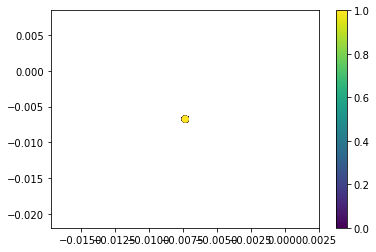

In [29]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# X shape (60,000 28x28), y shape (10,000, )

(X, y) = (train_data[0],train_data[1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)




# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# (x_train, _), (x_test, y_test) = mnist.load_data()

# data pre-processing
x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(2500,))

# encoder layers
# encoded = Dense(32768, activation='relu')(input_img)
# encoded = Dense(16384, activation='relu')(encoded)
# encoded = Dense(8192, activation='relu')(input_img)
encoded = Dense(2048, activation='relu')(input_img)
encoded = Dense(1024, activation='relu')(encoded)
encoded = Dense(512, activation='relu')(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
# encoded = Dense(2, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# # decoder layers
# decoded = Dense(2, activation='relu')(encoder_output)
decoded = Dense(10, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(1024, activation='relu')(decoded)
decoded = Dense(2048, activation='relu')(decoded)
decoded = Dense(2500, activation='relu')(decoded)
# # decoded = Dense(8192, activation='relu')(decoded)
# decoded = Dense(10000, activation='relu')(decoded)
# # decoded = Dense(32768, activation='relu')(decoded)
# # decoded = Dense(40000, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# training
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=255,
                shuffle=True)

# plotting
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()
